In [1]:
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use("ggplot")

We will create  a new variable that standardizes payroll conditioned on year. For each team and matching year, find the the average payroll for that year, and the standard deviation of payroll for that year

In [2]:
conn=pymysql.connect(host='localhost',port=int(3306),user='coreyy',passwd='******',db='lahmansbaseballdb')

## PART 1: 
### Data Wrangling

Extract from salaries file information about team IDs, year IDs and the sum of salaries as total payroll, then group the extracted data by year and team and order by team

In [3]:
salary_query = "SELECT teamID, yearID, sum(salary) as total_payroll FROM salaries GROUP BY yearID, teamID ORDER BY teamID"
team_salaries = pd.read_sql(salary_query, conn)

Extract from teams file information about team IDs, year IDs, wins, games, and compute win rate, then group the extracted data by year and team and order by team

In [4]:
winning_query = "SELECT teamID, yearID, W, G, 100*CAST(W AS float)/G AS win_rate, franchID FROM teams GROUP BY yearID, teamID ORDER BY teamID"
w = pd.read_sql(winning_query, conn)

Inner join these two tables to combine all information about each team and every year, also get rid of any missing data.

In [5]:
salary_wins = team_salaries.merge(w, how ="inner",left_on=["yearID", "teamID"],right_on=["yearID", "teamID"])
salary_wins

,teamID,yearID,total_payroll,W,G,win_rate,franchID
0,ANA,2000,51464167.0,82,162,50.617284,ANA
1,ANA,1999,55388166.0,70,162,43.209877,ANA
2,ANA,2004,100534667.0,92,162,56.790123,ANA
3,ANA,1998,41281000.0,85,162,52.469136,ANA
4,ANA,2003,79031667.0,77,162,47.530864,ANA
...,...,...,...,...,...,...,...
913,WAS,2006,63143000.0,71,162,43.827160,WSN
914,WAS,2011,63856928.0,80,161,49.689441,WSN
915,WAS,2016,141652646.0,95,162,58.641975,WSN
916,WAS,2005,48581500.0,81,162,50.000000,WSN


## Part 2: 
### EDA of the Data

code to produce visual plots that illustrate the distribution of payrolls across teams conditioned on time (from 1985-2016).

In [6]:
s_new = salary_wins[salary_wins.yearID > 1984]
s_new = s_new[s_new.yearID < 2017]
s_new = s_new.pivot(index ='teamID', columns='yearID', values='total_payroll')

This will be a stacked bar plot meaning each team is represented with a different color representing the salary amount for year

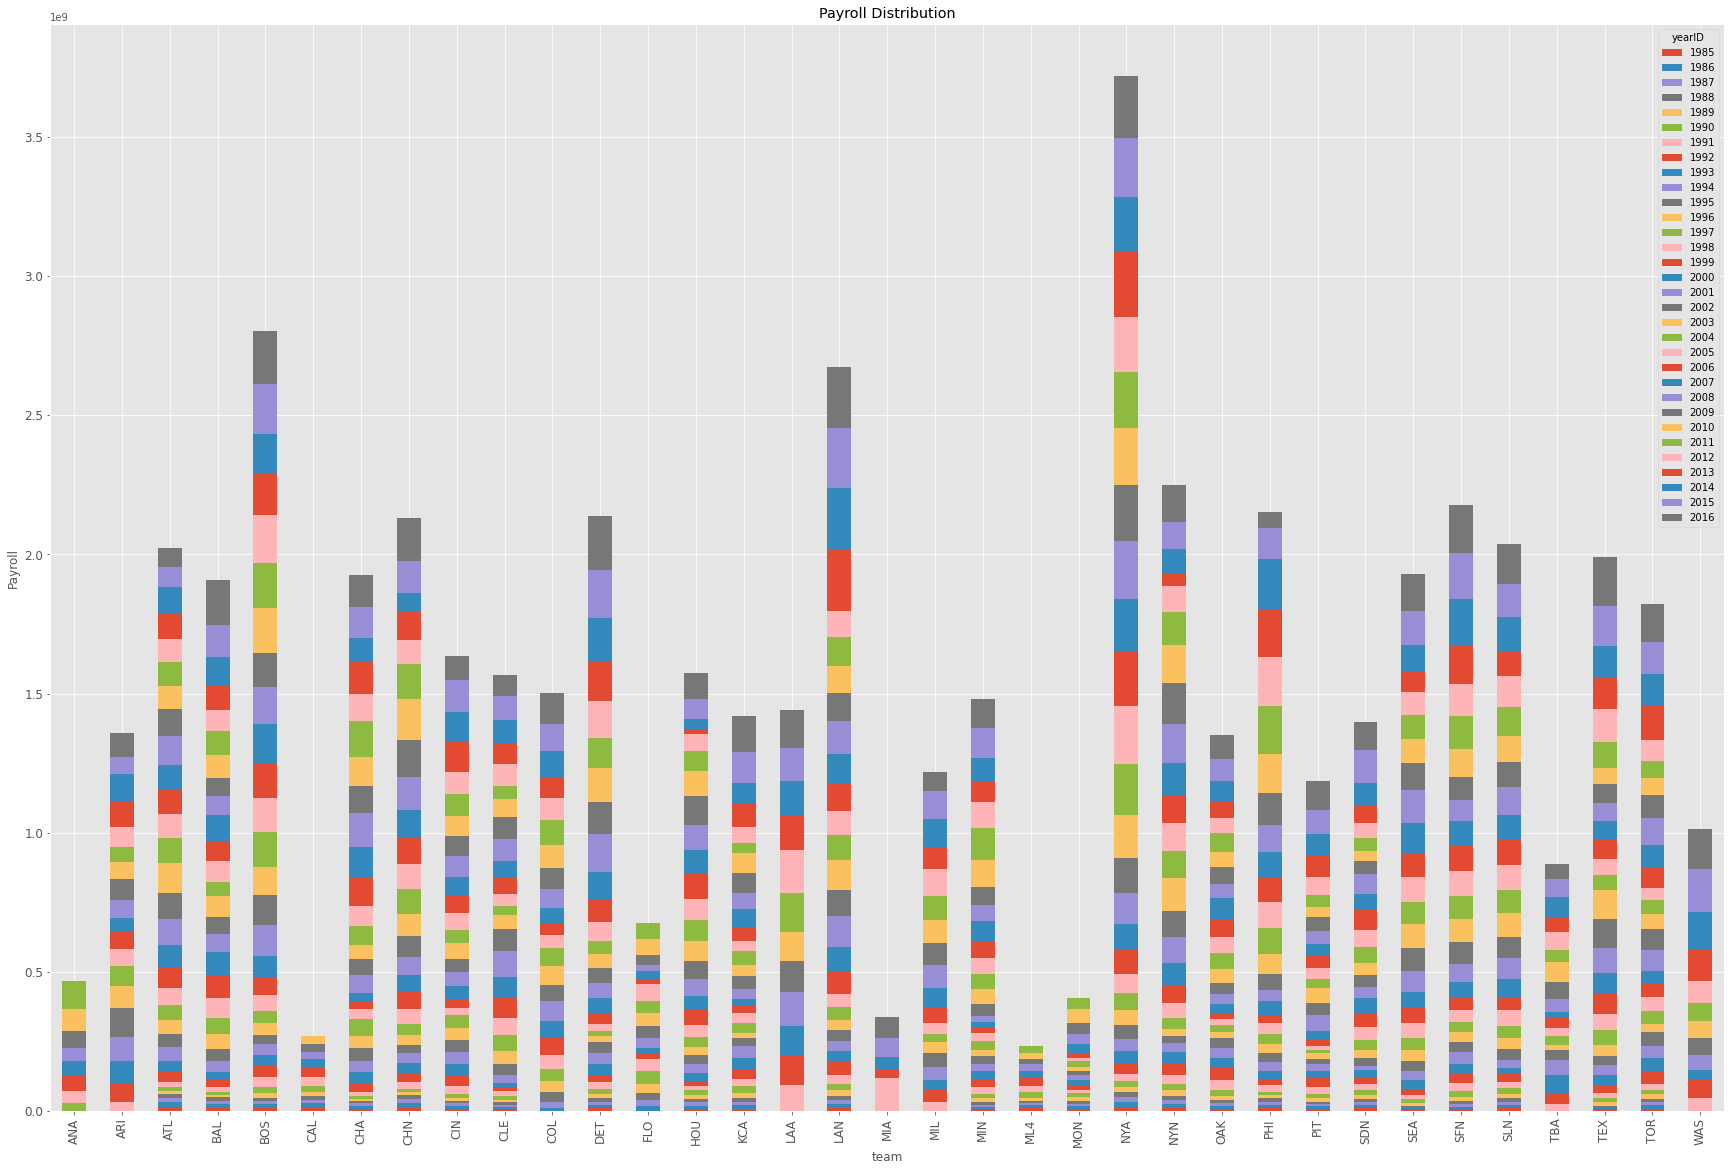

In [7]:
s_new.plot(kind = 'bar',title ="Payroll Distribution", stacked = True, figsize=(30, 20), legend=True, fontsize=12)
plt.xlabel("team")
plt.ylabel("Payroll")
plt.show()

From the plot we can see that each year the salary tends to increase slightly. 

## Part 3: 
### Visualizing From Part 1 

Compute mean and standard deviation for each year combining all teams 

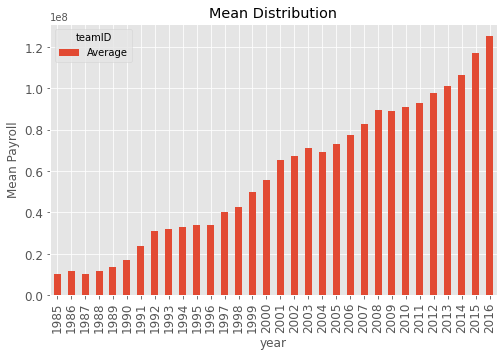

In [8]:
a = s_new.mean()
b = s_new.std()
s_new.loc['Average'] = a
s_new.loc['StandardDev'] = b
# Plot mean calculated above for every year
s_mean = s_new.drop(s_new.index[range(0,35)])
s_mean = s_mean.drop(s_mean.index[range(1,2)])
s_mean = s_mean.transpose()
s_mean.plot(kind = 'bar',title ="Mean Distribution", figsize=(8, 5), legend=True, fontsize=12)
plt.xlabel("year")
plt.ylabel("Mean Payroll")
plt.show()

## Part 4: 
### Looking at the coorelation of payroll to winning percentages

In [9]:
# Put year into five time periods
bins = [1990,1995,2000,2005,2010,2015]
group_names=['period_1','period_2','period_3','period_4','period_5']
salary_wins['period'] = pd.cut(salary_wins['yearID'],bins,right=False, labels=group_names)
salary_wins

,teamID,yearID,total_payroll,W,G,win_rate,franchID,period
0,ANA,2000,51464167.0,82,162,50.617284,ANA,period_3
1,ANA,1999,55388166.0,70,162,43.209877,ANA,period_2
2,ANA,2004,100534667.0,92,162,56.790123,ANA,period_3
3,ANA,1998,41281000.0,85,162,52.469136,ANA,period_2
4,ANA,2003,79031667.0,77,162,47.530864,ANA,period_3
...,...,...,...,...,...,...,...,...
913,WAS,2006,63143000.0,71,162,43.827160,WSN,period_4
914,WAS,2011,63856928.0,80,161,49.689441,WSN,period_5
915,WAS,2016,141652646.0,95,162,58.641975,WSN,NaN
916,WAS,2005,48581500.0,81,162,50.000000,WSN,period_4


Create a scatterplot showing the mean winning percentage (y-axis) vs. the
mean payroll (x-axis) for each of the created time periods. 

### Scatterplot Analysis

Period 1: The average payroll is increasing accross this period
Period 2: Using the interpolation line, we can see that teams with higher payroll leads to higher winning percentage.
Period 3: The NYA (New York Yankees) are consistently the top team for payroll. 
Period 4: Atlanta had a good year
Period 5: The Oakland atheletics are the only team that seems to have a decent winning perecentage despite having one of the lowest payrolls in the league. 

## Part 5 

### Data Transformation

We will create  a new variable that standardizes payroll conditioned on year. For each team and matching year, find the the average payroll for that year, and the standard deviation of payroll for that year

In [10]:
list1 = []
list2 = []
for i, row in salary_wins.iterrows():
    a = 0
    for year in s_new:
        if (year == (row['yearID'])):
            list1.append(s_new[year].Average)
            list2.append(s_new[year].StandardDev)
            a = a + 1
    if (a == 0):
        list1.append(np.NaN)
        list2.append(np.NaN)
        
# Populate the table 
averages = pd.DataFrame(list1, columns = ['raw'])
salary_wins['average'] = averages           
stddevs = pd.DataFrame(list2, columns = ['raw'])
salary_wins['standardDev'] = stddevs

# Add a new column for the standard payroll of each team and the year
salary_wins['std_payroll'] = (salary_wins['total_payroll']-salary_wins['average'])/ (salary_wins['standardDev'])
salary_wins

,teamID,yearID,total_payroll,W,G,win_rate,franchID,period,average,standardDev,std_payroll
0,ANA,2000,51464167.0,82,162,50.617284,ANA,period_3,5.553784e+07,2.141622e+07,-0.190214
1,ANA,1999,55388166.0,70,162,43.209877,ANA,period_2,4.980762e+07,2.056133e+07,0.271410
2,ANA,2004,100534667.0,92,162,56.790123,ANA,period_3,6.902220e+07,3.282411e+07,0.960040
3,ANA,1998,41281000.0,85,162,52.469136,ANA,period_2,4.260943e+07,1.538081e+07,-0.086369
4,ANA,2003,79031667.0,77,162,47.530864,ANA,period_3,7.094207e+07,2.801196e+07,0.288791
...,...,...,...,...,...,...,...,...,...,...,...
913,WAS,2006,63143000.0,71,162,43.827160,WSN,period_4,7.738242e+07,3.226495e+07,-0.441328
914,WAS,2011,63856928.0,80,161,49.689441,WSN,period_5,9.281684e+07,4.081197e+07,-0.709594
915,WAS,2016,141652646.0,95,162,58.641975,WSN,NaN,1.250046e+08,4.663199e+07,0.357010
916,WAS,2005,48581500.0,81,162,50.000000,WSN,period_4,7.295711e+07,3.417478e+07,-0.713263


## Part 6

Using the same pots as Part 4 with our new standardized payroll data. The mean winning percentage (y-axis) vs. mean standardized payroll (x-axis) for five time periods.

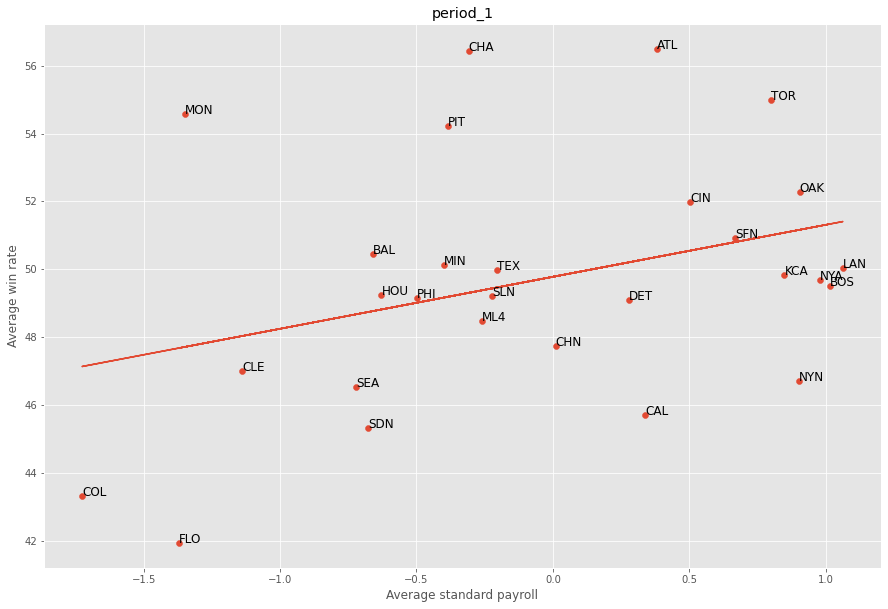

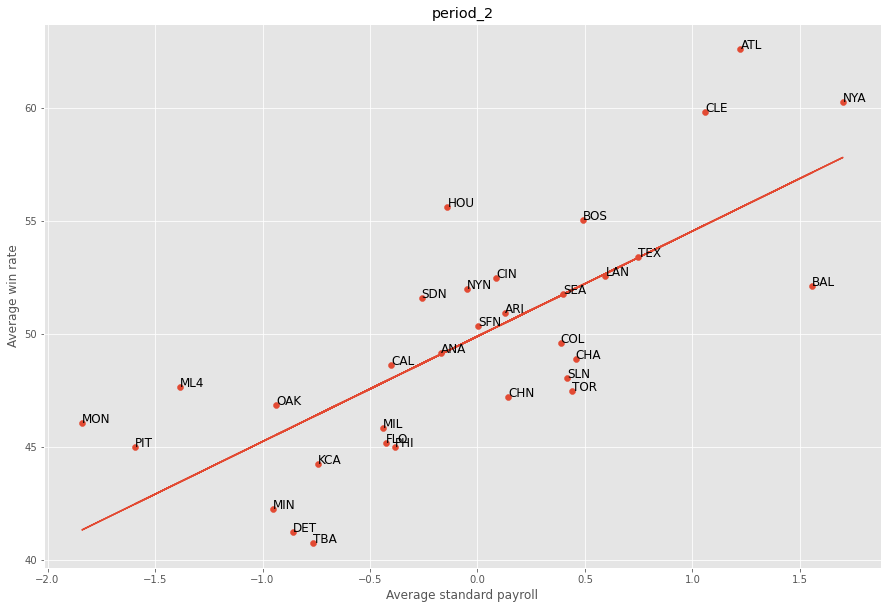

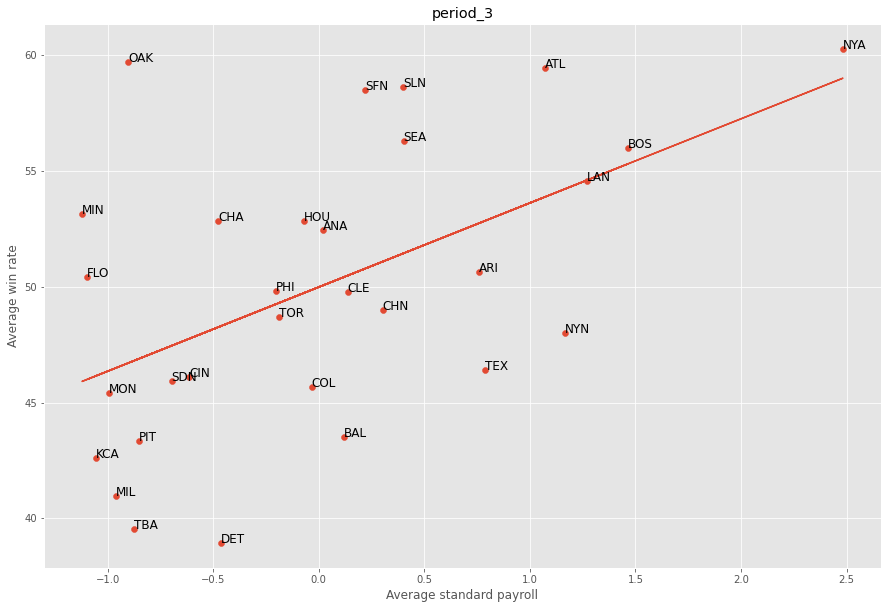

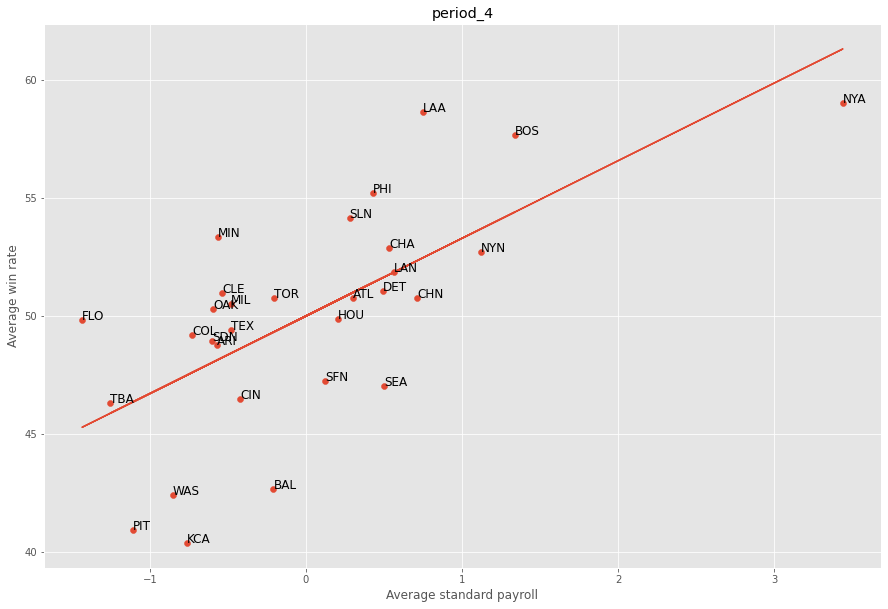

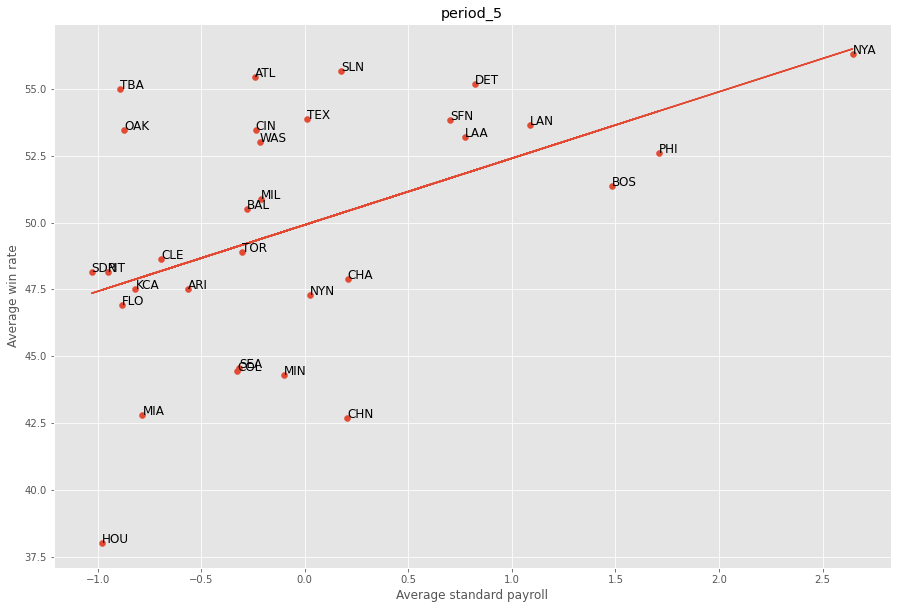

In [11]:
for period in group_names:
    # Computing average standardized payroll and win rate for each team per period
    s = salary_wins[salary_wins.period  == period]
    a = s.pivot(index='yearID', columns='teamID', values='std_payroll')
    b = s.pivot(index='yearID', columns='teamID', values='win_rate')
    x_data = a.mean().values
    y_data = b.mean().values
    # Making a scatter plot and drawing a regression line
    fit = np.polyfit(x = x_data,y = y_data,deg = 1)
    plt.figure(figsize = (15,10))
    plt.plot(x_data, fit[0] * x_data + fit[1])
    plt.scatter(x_data, y_data)
    a = a.transpose()
    # annotate each point with its team name.
    for i, txt in enumerate(a.index):
        plt.annotate(txt, (x_data[i],y_data[i]),size=12)
    plt.xlabel("Average standard payroll")
    plt.ylabel("Average win rate")
    plt.title(period)
    plt.show()

## Analysis

The shape of the plots in Probelm 6 are almost the same as the polts in Problem 4 even though the unit and the range of X-coordinate changed here. Standardization shows which data is near the mean point directly, and to what degree is it away from the mean.

## Part 7

Using the entire range of years, create a single scatter plot of winning percentage (y-axis) vs. standardized payroll (x-axis).

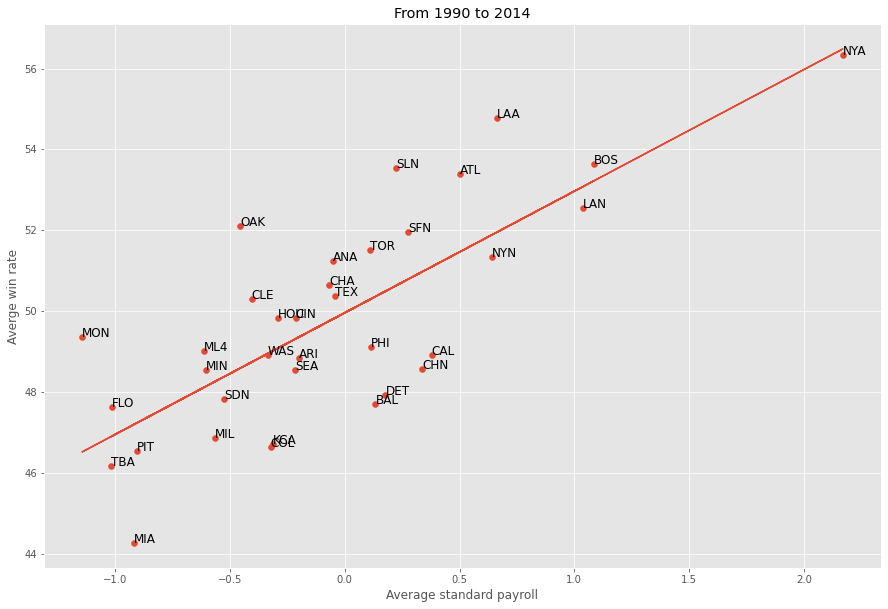

In [12]:
# Get thee average total payroll and win rate for each team
a = salary_wins.pivot(index='yearID', columns='teamID', values='std_payroll')
b = salary_wins.pivot(index='yearID', columns='teamID', values='win_rate')
x_data = a.mean().values
y_data = b.mean().values

# Create a plot with a regression line
fit = np.polyfit(x = x_data,y = y_data,deg = 1)
plt.figure(figsize = (15,10))
plt.plot(x_data, fit[0] * x_data + fit[1])
plt.scatter(x_data, y_data)
a = a.transpose()

# name each point.
for i, txt in enumerate(a.index):
    plt.annotate(txt, (x_data[i],y_data[i]),size=12)
plt.xlabel("Average standard payroll")
plt.ylabel("Averge win rate")
plt.title("From 1990 to 2014")
plt.show()

In [13]:
# Add a new column to the table
salary_wins['expected_win_pct'] = 50 + 2.5*salary_wins['std_payroll']
salary_wins

,teamID,yearID,total_payroll,W,G,win_rate,franchID,period,average,standardDev,std_payroll,expected_win_pct
0,ANA,2000,51464167.0,82,162,50.617284,ANA,period_3,5.553784e+07,2.141622e+07,-0.190214,49.524464
1,ANA,1999,55388166.0,70,162,43.209877,ANA,period_2,4.980762e+07,2.056133e+07,0.271410,50.678524
2,ANA,2004,100534667.0,92,162,56.790123,ANA,period_3,6.902220e+07,3.282411e+07,0.960040,52.400100
3,ANA,1998,41281000.0,85,162,52.469136,ANA,period_2,4.260943e+07,1.538081e+07,-0.086369,49.784077
4,ANA,2003,79031667.0,77,162,47.530864,ANA,period_3,7.094207e+07,2.801196e+07,0.288791,50.721977
...,...,...,...,...,...,...,...,...,...,...,...,...
913,WAS,2006,63143000.0,71,162,43.827160,WSN,period_4,7.738242e+07,3.226495e+07,-0.441328,48.896680
914,WAS,2011,63856928.0,80,161,49.689441,WSN,period_5,9.281684e+07,4.081197e+07,-0.709594,48.226016
915,WAS,2016,141652646.0,95,162,58.641975,WSN,NaN,1.250046e+08,4.663199e+07,0.357010,50.892524
916,WAS,2005,48581500.0,81,162,50.000000,WSN,period_4,7.295711e+07,3.417478e+07,-0.713263,48.216842


## Part 8 :

Let's find out the team spending efficiency. 

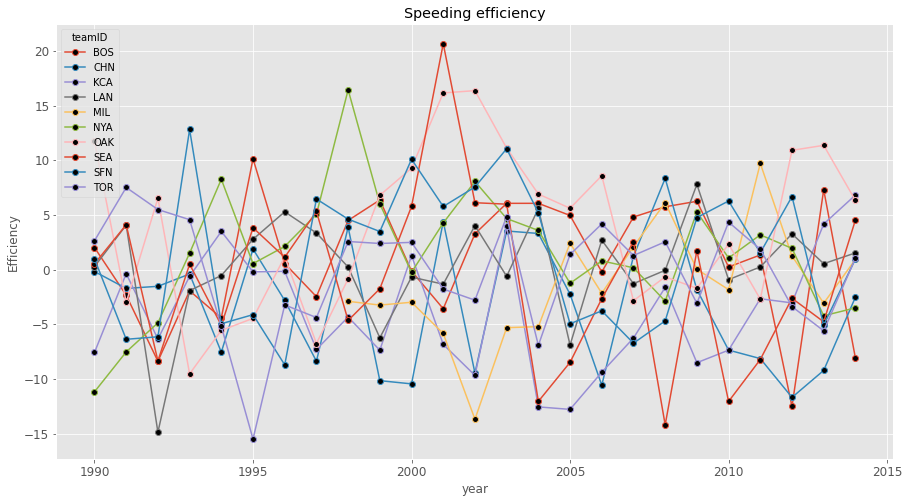

In [14]:
salary_wins['efficiency'] = salary_wins['win_rate'] - salary_wins['expected_win_pct']

# Get efficiency data within the range
s_efficiency = salary_wins[salary_wins.yearID > 1989]
s_efficiency = s_efficiency[s_efficiency.yearID < 2015]

# Get efficiency data for each of the suggested teams
s1 = s_efficiency[s_efficiency.teamID == 'BOS' ]
s2 = s_efficiency[s_efficiency.teamID == 'TOR' ]
s3 = s_efficiency[s_efficiency.teamID == 'OAK' ]
s4 = s_efficiency[s_efficiency.teamID == 'NYA' ]
s5 = s_efficiency[s_efficiency.teamID == 'SEA' ]
s6 = s_efficiency[s_efficiency.teamID == 'SFN' ]
s7 = s_efficiency[s_efficiency.teamID == 'MIL' ]
s8 = s_efficiency[s_efficiency.teamID == 'KCA' ]
s9 = s_efficiency[s_efficiency.teamID == 'LAN' ]
s10 = s_efficiency[s_efficiency.teamID == 'CHN' ]

# Go through each team
frames = [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10]
s_efficiency = pd.concat(frames)

# Create a plot with year on the x-axis and efficiency on the y-axis. 
# Plotting a few teams 
s_efficiency = s_efficiency.pivot(index='yearID', columns='teamID', values='efficiency')
s_efficiency.plot(kind = 'line',title ="Speeding efficiency", markevery = 1, marker='o', markerfacecolor='black', figsize=(15, 8), legend=True, fontsize=12)
plt.xlabel("year")
plt.ylabel("Efficiency")
plt.show()